In [1]:
%load_ext autoreload
%autoreload 2

In [ ]:
# clone repo
# !git clone https://github.com/mahmoodlab/HIPT.git

In [141]:
import sys

sys.path.append("./HIPT/HIPT_4K/")

import torch
from PIL import Image, ImageFile

ImageFile.LOAD_TRUNCATED_IMAGES = True
print(ImageFile.LOAD_TRUNCATED_IMAGES)
from torchinfo import summary
import seaborn as sns
from einops import rearrange, repeat
from HIPT.HIPT_4K.hipt_4k import HIPT_4K
from HIPT.HIPT_4K.hipt_model_utils import eval_transforms
import torchvision.transforms as T
from torchvision.models import resnet50, convnext_base, convnext_large, efficientnet_v2_s, efficientnet_v2_m
from torchvision.models import ResNet50_Weights, ConvNeXt_Large_Weights, ConvNeXt_Base_Weights, EfficientNet_V2_S_Weights, EfficientNet_V2_M_Weights
from torchvision.models.feature_extraction import create_feature_extractor
from torchvision.models.feature_extraction import get_graph_node_names
from torchvision.transforms.functional import pad
from hipt_model_utils import (
    get_vit256,
    get_vit4k,
    tensorbatch2im,
    eval_transforms,
    roll_batch2img,
)
import vision_transformer as vit
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC
from functools import partial

from utils.utils import *
from utils.vit_utils import *
from utils.cross_val import *

True


## Check untransformed data

In [19]:
train_set, train_loader, test_set, test_loader = check_data()

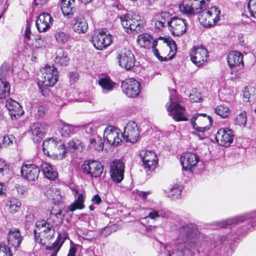

In [4]:
small_region = Image.open("./HIPT/HIPT_4K/image_demo/image_256.png")
small_region

In [31]:
min_dims = []
for img in test_set.orig_images:
    min_dims.append(min(img.size))

max_dims = []
for img in test_set.orig_images:
    max_dims.append(max(img.size))


(array([ 2.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  1.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  8.,
         0.,  0.,  0.,  0.,  8.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
         0., 19.,  0.,  0.,  0.,  0., 18.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0., 11., 17.,  0.,  0.,  0.,  0., 18.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.,  5.,  7.,  0.,  0.,  0.,  0.,  0.,  4.,  0.,
         0.,  1.,  0.,  0.,  0.,  0.,  1.,  2.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  2.]),
 array([218.  , 221.28, 224.56, 227.84, 231.12, 234.4 , 237.68, 240.96,
        244.24, 247.52, 250.8 , 254.08, 257.36, 260.64, 263.92, 267.2 ,
        270.48, 273.76, 277.04, 280.32, 283.6 , 286.88, 290.16, 293.44,
        296.72, 300.  , 303.28, 306.56, 309.84, 313.12, 316.4 , 319.68,
        322.96, 326.24, 329.52, 332.8 , 336.08, 339.36, 342.64, 345.92,
        349.2 , 352.48, 355.76, 359.04, 362.32, 365.6 , 368.88, 372.16,
  

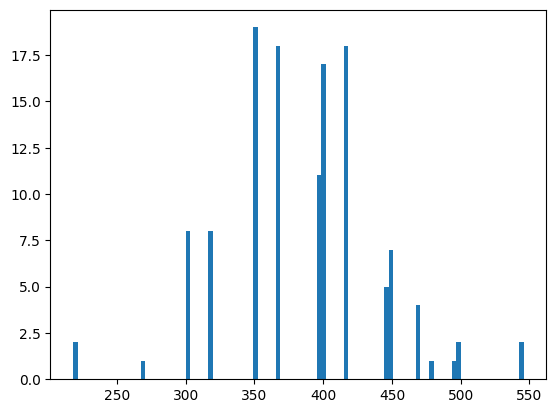

In [204]:
plt.hist(min_dims, bins=100)

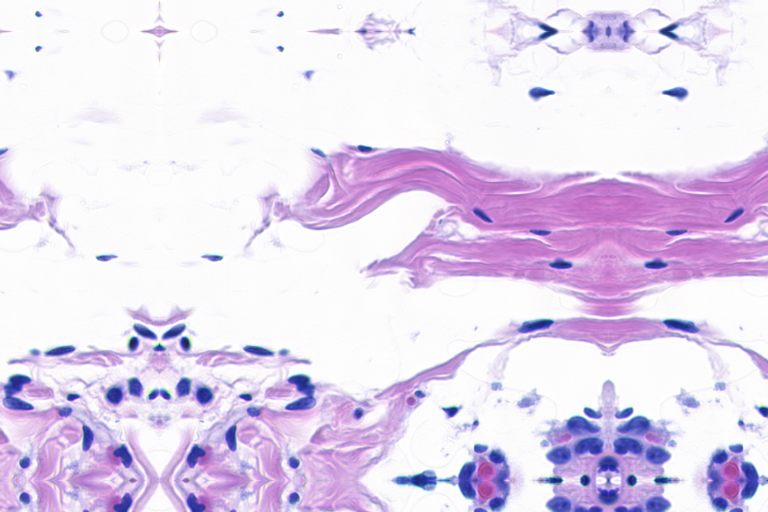

In [8]:
test_set.images[10]

## Define model

In [9]:
model = vit.vit_small(patch_size=16, num_classes=0)

# feature_extractor.eval();
checkpoint_key = "teacher"
pretrained_weights = "./HIPT/HIPT_4K/Checkpoints/vit256_small_dino.pth"
device = torch.device("cuda:0")
for p in model.parameters():
    p.requires_grad = False
model.eval()
model.to(device)
if os.path.isfile(pretrained_weights):
    state_dict = torch.load(pretrained_weights, map_location="cpu")
    if checkpoint_key is not None and checkpoint_key in state_dict:
        print(f"Take key {checkpoint_key} in provided checkpoint dict")
        state_dict = state_dict[checkpoint_key]
    # remove `module.` prefix
    state_dict = {k.replace("module.", ""): v for k, v in state_dict.items()}
    # remove `backbone.` prefix induced by multicrop wrapper
    state_dict = {k.replace("backbone.", ""): v for k, v in state_dict.items()}
    msg = model.load_state_dict(state_dict, strict=False)
    print(
        "Pretrained weights found at {} and loaded with msg: {}".format(
            pretrained_weights, msg
        )
    )
feature_extractor = model

Take key teacher in provided checkpoint dict
Pretrained weights found at ./HIPT/HIPT_4K/Checkpoints/vit256_small_dino.pth and loaded with msg: _IncompatibleKeys(missing_keys=[], unexpected_keys=['head.mlp.0.weight', 'head.mlp.0.bias', 'head.mlp.2.weight', 'head.mlp.2.bias', 'head.mlp.4.weight', 'head.mlp.4.bias', 'head.last_layer.weight_g', 'head.last_layer.weight_v'])


In [10]:
example = train_set[0][0]

In [11]:
example.shape

torch.Size([3, 512, 768])

In [56]:
batch = example.unsqueeze(0)
patches, num_patches = extract_patches(batch, size=224)

stride_h: 144, stride_w: 181


In [48]:
patches.shape

torch.Size([12, 3, 224, 224])

In [ ]:
for patch in patches:
    plt.imshow(patch.cpu().numpy().transpose(1, 2, 0))
    plt.show()

In [6]:

# # load different pretrained model
# # weights = ConvNeXt_Large_Weights.DEFAULT
# # model = convnext_large(weights=weights)

# # weights = ConvNeXt_Base_Weights.DEFAULT
# # model = convnext_base(weights=weights)

# weights = EfficientNet_V2_S_Weights.DEFAULT
# model = efficientnet_v2_s(weights=weights)
# return_nodes = {
#     "flatten": "out",
#     # "classifier.0": "out"
# }
# train_nodes, eval_nodes = get_graph_node_names(model)
# train_nodes[-10::]

# # return_nodes = ["classifier.1"]
# feature_extractor = create_feature_extractor(model, return_nodes=return_nodes)
# feature_extractor = FeatureExtractor(feature_extractor)

# device = torch.device("cuda:7" if torch.cuda.is_available() else "cpu")
# # device = "cpu"
# print(f"Using device: {device}")
# feature_extractor.to(device);
# feature_extractor.eval();
# model_transforms = weights.transforms(antialias=True)

In [59]:
with torch.no_grad():
    for batch in train_loader:
        img, label = batch
        img = img.to(device)
        patches, num_patches = extract_patches(img, size=224)
        out = feature_extractor(patches)
        out = out.reshape(-1, num_patches * out.shape[-1])

out.shape

stride_h: 144, stride_w: 181


torch.Size([62, 4608])

## Setup data

In [61]:
data_dir = "./data"
image_dir = f"{data_dir}/oxml-carinoma-classification"
image_paths, label_path = get_image_and_label_paths(image_dir)
image_paths[0:1], len(image_paths)

labels_df = pd.read_csv(label_path)
labels = labels_df["malignant"].tolist()
train_ids = labels_df["id"].tolist()
train_set_paths, test_set_paths = get_train_test_paths(image_paths, train_ids=train_ids)
len(train_set_paths), len(test_set_paths)

(62, 124)

Index([-1, 0, 1], dtype='int64', name='malignant')
Index(['negative', 'benign', 'malignant'], dtype='object', name='malignant')


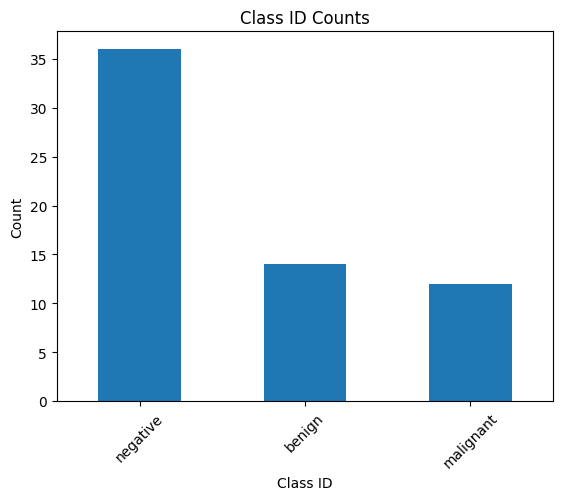

In [62]:
labels_df = pd.read_csv(label_path)
analyze_class_distribution(labels_df)

In [153]:
seed_everything(42)

In [154]:
test_transforms = T.Compose([eval_transforms()])
train_transforms = T.Compose([eval_transforms()])
train_set, train_loader, test_set, test_loader = prepare_train_test_data(
    image_paths,
    train_ids,
    labels,
    train_transforms=train_transforms,
    test_transforms=test_transforms,
    train_batch_size=62,
    test_batch_size=1024,
    num_workers=8,
    one_hot=False,
)

In [155]:
test_transforms = T.Compose([eval_transforms()])
train_transforms = T.Compose(
    [
        T.RandomHorizontalFlip(p=0.5),
        T.RandomVerticalFlip(p=0.5),
        T.ColorJitter(brightness=0.5, contrast=0.5, saturation=0.5, hue=0),
        T.GaussianBlur(kernel_size=3, sigma=(0.1, 2.0)),
        eval_transforms(),
    ]
)
(
    train_set_mod,
    train_loader_mod,
    test_set_mod,
    test_loader_mod,
) = prepare_train_test_data(
    image_paths,
    train_ids,
    labels,
    train_transforms=train_transforms,
    test_transforms=test_transforms,
    train_batch_size=62,
    test_batch_size=1024,
    num_workers=8,
    one_hot=False,
)

In [152]:
6 // 5

1

## Extract features

In [156]:
patch_size = 224
X_train, y_train = extract_feature_sets(
    feature_extractor, train_loader, device=device, patch_size=patch_size
)
X_test, y_test = extract_feature_sets(
    feature_extractor, test_loader, device=device, patch_size=patch_size
)
X_train_mod, y_train_mod = extract_feature_sets(
    feature_extractor,
    train_loader_mod,
    num_samples_target=len(train_set) * 4,
    device=device,
    patch_size=patch_size,
)

X.shape: (62, 4608), y.shape: (62,)
X.shape: (124, 4608), y.shape: (124,)
X.shape: (248, 4608), y.shape: (248,)


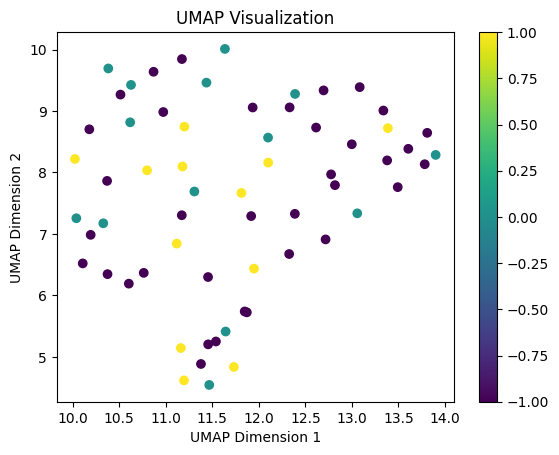

In [140]:
visualize_umap(X_train, y_train)

## Run Classifier

In [189]:
from sklearn.gaussian_process import GaussianProcessClassifier
from sklearn.gaussian_process.kernels import RBF
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.pipeline import make_pipeline

In [198]:
# classifier = GaussianProcessClassifier(1.0 * RBF(1.0))
classifier = SVC(gamma="auto", C=2, class_weight="balanced")
# classifier = RandomForestClassifier(max_depth=5, n_estimators=10, max_features=1)

# Create the pipeline
pipeline = make_pipeline(StandardScaler(), classifier)

In [199]:
classifier = cross_validate(pipeline, X_train, y_train, X_train_mod, y_train_mod, splits=5)

Fold 0:
(245, 4608) (245,)
Train F1 micro: 1.0
Test F1 micro: 0.6153846153846154
Fold 1:
(245, 4608) (245,)
Train F1 micro: 1.0
Test F1 micro: 0.6153846153846154
Fold 2:
(250, 4608) (250,)
Train F1 micro: 1.0
Test F1 micro: 0.5833333333333334
Fold 3:
(250, 4608) (250,)
Train F1 micro: 1.0
Test F1 micro: 0.5833333333333334
Fold 4:
(250, 4608) (250,)
Train F1 micro: 1.0
Test F1 micro: 0.5833333333333334
Average train F1 micro: 1.0
Average test F1 micro: 0.5961538461538463


In [200]:
X_train_full = np.concatenate([X_train, X_train_mod])
y_train_full = np.concatenate([y_train, y_train_mod])
classifier.fit(X_train_full, y_train_full)
y_test_pred = classifier.predict(X_test)
y_train_pred = classifier.predict(X_train)
f1_micro_train = f1_score(y_train, y_train_pred, average="micro")
print(f"f1_micro_train: {f1_micro_train}")

f1_micro_train: 1.0


In [201]:
# y_train_pred, y_test_pred = run_sklearn_classifier(pipeline, X_train, y_train, X_test)

In [202]:
y_train_pred

array([-1, -1,  1, -1, -1,  0,  0,  0,  0,  0, -1,  1,  0, -1,  0,  0, -1,
        0, -1,  1, -1,  1,  1,  0, -1, -1, -1,  1, -1, -1,  1, -1, -1,  1,
       -1, -1, -1,  0,  0,  1,  0, -1, -1, -1, -1, -1, -1, -1, -1, -1,  1,
        1, -1, -1, -1,  1, -1, -1, -1,  0, -1, -1])

## Save submission

Index([-1, 1], dtype='int64', name='malignant')
Index(['negative', 'malignant'], dtype='object', name='malignant')


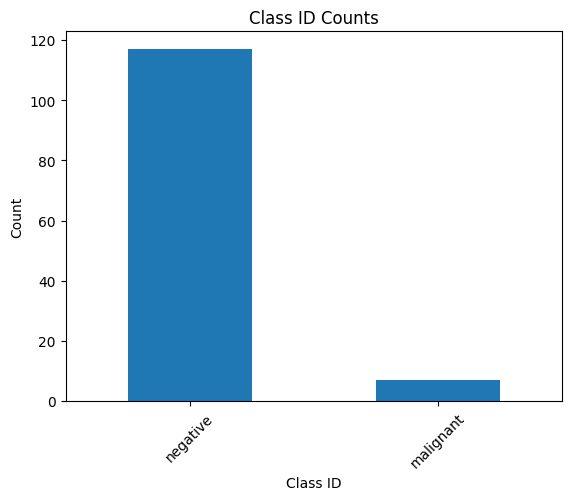

In [203]:
submission = create_submission_file(test_set_paths, y_test_pred)